In [194]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import math as mt
import scipy.special
import seaborn as sns
plt.style.use('fivethirtyeight')

# <font face="gotham" color="orange"> Markov Chain Monte Carlo </font>

The **Markov Chain Monte Carlo** (**MCMC**) is a class of algorithm to simulate a distribution that has no closed-form expression. To illustrate the mechanism of MCMC, we resort to the example of Gamma-Poisson conjugate.

Though it has a closed-form expression of posterior, we can still simulate the posterior for demonstrative purpose.

To use MCMC, commonly the Bayes' Theorem is modified without affecting the final result.
$$
P(\lambda \mid y) \propto P(y \mid \lambda)  P(\lambda)
$$
where $\propto$ means proportional to, the integration in the denominator can be safely omitted since it is a constant.

Here we recap the example of hurricanes in the last chapter. The prior elicitation uses


$$
E(\lambda) = \frac{\alpha}{\beta}\\
\text{Var}(\lambda) = \frac{\alpha}{\beta^2}
$$

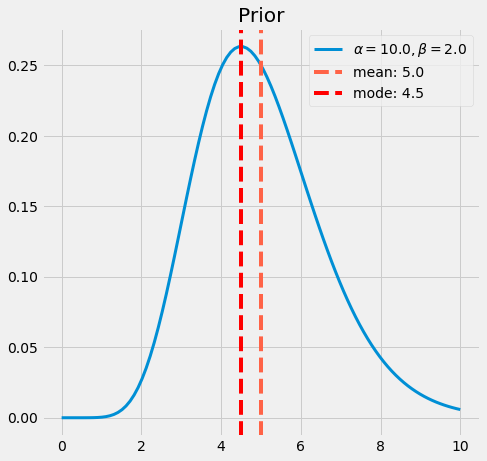

In [2]:
x = np.linspace(0, 10, 100)
params = [10, 2]
gamma_pdf = sp.stats.gamma.pdf(x, a=params[0], scale=1/params[1])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, gamma_pdf, lw = 3, label = r'$\alpha = %.1f, \beta =  %.1f$' % (params[0], params[1]))
ax.set_title('Prior')
mean = params[0]/params[1]
mode = (params[0]-1)/params[1]
ax.axvline(mean, color = 'tomato', ls='--', label='mean: {}'.format(mean))
ax.axvline(mode, color = 'red', ls='--', label='mode: {}'.format(mode))
ax.legend()
plt.show()

1. Because posterior will also be Gamma distribution, we start from proposing a value drawn from posterior
$$
\lambda = 8
$$
This is an arbitrary value, it is called the **initial value**. 

2. Calculate the likelihood of observing $k=3$ hurricanes given $\lambda=8$.
$$
\mathcal{L}(3 ; 8)=\frac{\lambda^{k} e^{-\lambda}}{k !}=\frac{8^{3} e^{-8}}{3 !}=0.1075
$$

In [3]:
def pois_lh(k, lamda):
    lh = lamda**k*np.exp(-lamda)/mt.factorial(k)
    return lh

In [4]:
lamda_init = 8
k = 3
pois_lh(k = k, lamda = lamda_init)

0.02862614424768101

3. Calculate prior 
$$
g(\lambda ; \alpha, \beta)=\frac{\beta^{\alpha} \lambda^{\alpha-1} e^{-\beta \lambda}}{\Gamma(\alpha)}
$$

In [86]:
def gamma_prior(alpha, beta, lamda):
    prior = (beta**alpha*lamda**(alpha-1)*np.exp(-beta*lamda))/sp.special.gamma(alpha)
    return prior

In [88]:
lamda_current = lamda_init
alpha=10
beta=2
gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current)

0.0426221247856141

4. Calculate the posterior with the first guess $\lambda=8$ and we denote it as $\lambda_{current}$

In [98]:
k=3
posterior_current = pois_lh(k=k, lamda=lamda_current) * gamma_prior(alpha=10, beta=2, lamda=lamda_current)
posterior_current

0.0012201070922556493

5. Draw a second value for $\lambda_{next}$ in a normal distribution centered at $\mu=\lambda_{current}$ and standard deviation $\sigma = .5$. The $\sigma$ here is called **tuning parameter**.

In [84]:
turning_param = .5
lamda_next = sp.stats.norm(loc=lamda_current, scale=turning_param).rvs()
lamda_next

7.918951422728457

6. Calculate posterior based on the $\lambda_{next}$.

In [95]:
posterior_next = gamma_prior(alpha, beta, lamda=lamda_next)*pois_lh(k, lamda=lamda_next)
posterior_next

0.0013769783243079386

7. Now we have two posterior. To proceed, we need to make some rules to throw one away. Here we introduce the simplified **Metropolis-Hasting Algorithm**. The probability threshold for accepting next posterior is 
$$
p_{\text {next }}=\min \left(\frac{P\left(\lambda_{\text {next }} \mid \text { data }\right)}{P\left(\lambda_{\text {current }} \mid \text { data }\right)}, 1\right)
$$

In [99]:
print(posterior_current)
print(posterior_next)

0.0012201070922556493
0.0013769783243079386


In [107]:
prob_next = np.min([posterior_next/posterior_current, 1])
prob_next

1.0

It means the probability of accepting $\lambda_{next}$ is $1$. What if the smaller value is $\frac{\text{posterior next}}{\text{posterior current}}$, let's say $\text{prob_next}=.768$. The algorithm requires a draw from a uniform distribution, if the draw is smaller than $.768$, go for $\lambda_{next}$ if larger then stay with $\lambda_{current}$.

8. The algorithm will be

In [126]:
if sp.stats.uniform.rvs() > .768:
    print('stay with current lambda')
else:
    print('accept next lambda')

stay with current lambda


9. If we accept $\lambda_{next}$, redenote it as $\lambda_{current}$, then repeat from step $2$ for thousands of times. 

## <font face="gotham" color="orange"> Join Steps with a Loop </font>

We will join all the steps in a loop for thousands of times (the number of repetition depends on your time constraint and your computer's power).

In [224]:
np.random.seed(123)
lamda_init = 2
k = 3

alpha=10
beta=2

lamda_current = lamda_init
turning_param = 1

lamda_mcmc = []
pass_rate = []
post_ratio_list = []
sample = 10000
for i in range(sample):
    lh_current = pois_lh(k = k, lamda = lamda_current)
    prior_current = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_current)
    posterior_current = lh_current*prior_current
    
    lamda_next = sp.stats.norm(loc=lamda_current, scale=turning_param).rvs()
    prior_next = gamma_prior(alpha=alpha, beta=beta, lamda=lamda_next)
    lh_next = pois_lh(k, lamda=lamda_next)
    
    posterior_next = lh_next*prior_next
    post_ratio = posterior_next/posterior_current
    
    prob_next = np.min([post_ratio, 1])
    unif_draw = sp.stats.uniform.rvs()
    post_ratio_list.append(post_ratio)
    
    if unif_draw < prob_next:
        lamda_current = lamda_next
        lamda_mcmc.append(lamda_current)
        pass_rate.append('Y')
    else:
        lamda_mcmc.append(lamda_current)
        pass_rate.append('Y')

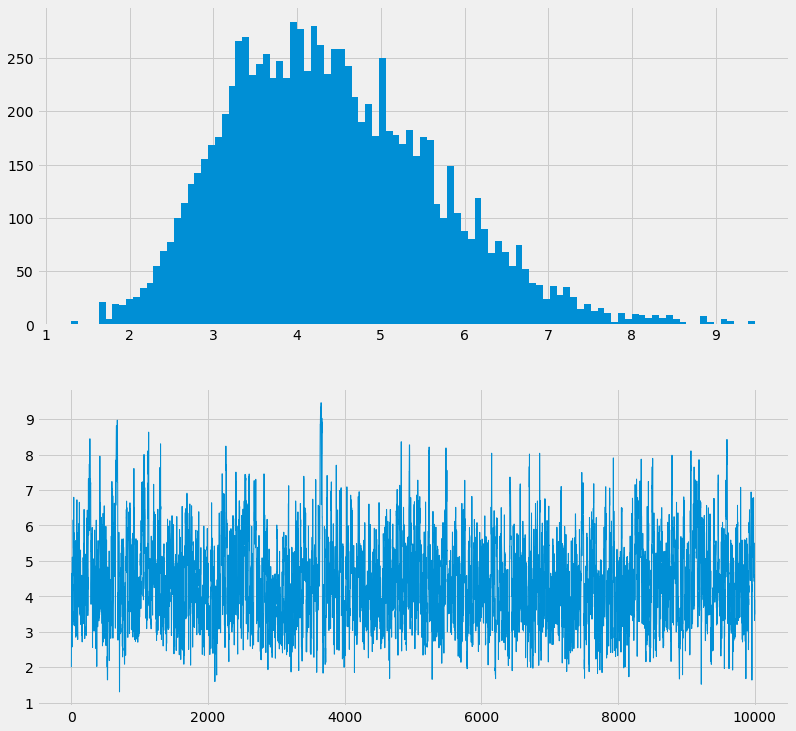

In [224]:
fig, ax = plt.subplots(figsize = (12, 12), nrows = 2, ncols = 1)
ax[0].hist(lamda_mcmc, bins=100)
ax[1].plot(np.arange(len(lamda_mcmc)), lamda_mcmc, lw=1)
plt.show()

In [186]:
data = np.random.randn(20)

In [189]:
def sampler(data, samples=1000, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = sp.stats.norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = sp.stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = sp.stats.norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = sp.stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = sp.stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)


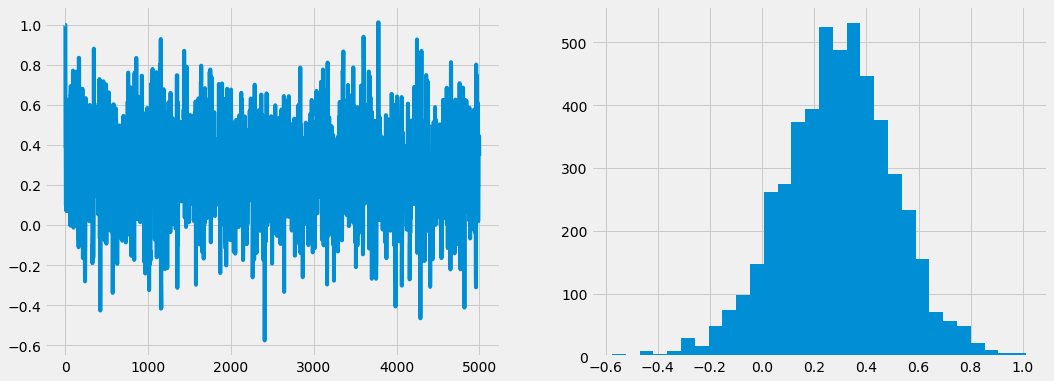

In [205]:
posterior = sampler(data, samples=5000, mu_init=1.)
fig, ax = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
ax[0].plot(posterior)
ax[0].set_xlabel='sample'
ax[0].set_xlabel='mu'
ax[1].hist(posterior, bins=30)
plt.show()

15001